In [1]:
import torch
import math
import numpy as np
dtype = torch.float
device = torch.device("cpu")
from matplotlib import pyplot as plt
import GPE_ensemble as GPE
import pandas as pd
import scipy
from  torch.distributions import normal

yobs = 8.0
sigma2 = 1.0


First we'll learn how to get the variational posterior for $x | y$ for a single value of y. We have
$$y= 4x-x^2/2+N(0,\sigma^2)$$

## Variational inference

Maximize the ELBO
$$ELBO(q) = E[\log p(y | x)] − KL (q(x)|| p(x)).$$

We'll use $q(x) = N(m, s^2)$ as the variational family
In this case, the ELBO can be computed exactly, but its a pain to do. So I've approximated the E[log p(y | x)] with a Monte Carlo sum.
$\Phi=(m, \log s^2)$ are the variational parameters


KL (q(x) || p(x)) = E[log q(x)] − E[log p(x)]
where expectations are with respect to q.

Note, if $p(x) \propto 1$, then $E\log p(x)$ does not depend on $\phi$ so can be ignored
If $q(x) =N(m, \sigma^2)$, then $E[\log q(x)] = -0.5 \log(2 \pi \sigma^2) - 1/2$

0


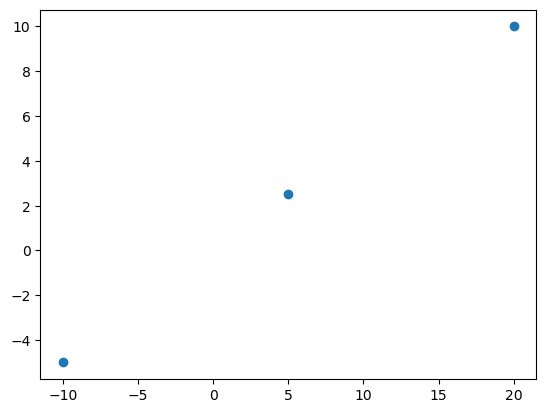

In [2]:
p=3

rl = -10
ru=20

obs_error = 0.001

x=torch.linspace(rl,ru,p)

b=0.5

def lin(x):
    y = b*x
    return y

y = lin(x) 

plt.plot(x[:,None],y[:,None],'o')

emulator = GPE.ensemble(x[:,None],y[:,None],mean_func="constant",training_iter=500)

In [3]:
x.shape

torch.Size([3])

In [4]:
def ELBO(m,log_s2,x,emulator,y,prior_mean,prior_cov,obs_error):
    param=[m,log_s2]
    L=torch.zeros((x.shape[0],x.shape[0]))
    mu = torch.tensor((param[0:x.shape[0]]))
    L=L.diagonal_scatter(torch.exp(torch.tensor(param[x.shape[0]:2*x.shape[0]])),0)
    #L[1,0]=param[6]
   # L[2,0]=param[7]
   # L[2,1] =param[8]
    covar = torch.matmul(L,L.T)
    z=x*torch.exp(log_s2/2.)+m
    
    z=z.T
    
    mc_int = torch.sum(emulator.ensemble_log_likelihood_obs_error(z,y,obs_error)+torch.log(x_prior(z,prior_mean,prior_cov)).squeeze())
        #mc_int +=-np.log(np.sum(((emulator.predict(z.iloc[[i]]).detach().numpy()-y.values)**2)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov))
        #mc_int += (np.sum(np.log(emulator.ensemble_likelihood(z.iloc[[i]],y)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov)))
    
    lb = mc_int/x.shape[1] - q_prior(covar)
    #print(mc_int/x.shape[1])
    #print(-q_prior(covar))
    #print(np.mean(z,axis=0))
    #print(-lb)
    return -lb

def x_prior(x,mean,cov):

    #var = scipy.stats.multivariate_normal(mean=mean, cov=cov)
    #val1 = var.pdf(x)
    dist = normal.Normal(loc=mean, scale=torch.sqrt(cov))
    val = torch.exp(dist.log_prob(x))
    return val

def q_prior(covar):
    qp = -(covar.shape[0]/2)*(1+torch.log(torch.tensor(2*torch.pi)))-0.5*torch.log(torch.linalg.det(covar))
    return qp

def f_likelihood(x,y,f,sigma2):
    
    likelihood_manual=-0.5*((f(x) - y)**2)/(sigma2)- 0.5*torch.log(2*np.pi)-0.5*torch.log(sigma2)
    return likelihood_manual

In [5]:
def KL(log_var):   
    return(-0.5*np.log(2.0*math.pi)-0.5*log_var-0.5)

def f(x):
    return(4.*x-0.5*torch.pow(x,2.))
# How do we define functions? x needs declaring?




def ZtoX(m, log_s2):
    #reparameterization trick
    return(Z*torch.exp(log_s2/2.)+m)


In [6]:

def log_dnorm(x, mean, var):
    return(-(x-mean).pow(2)/(2.*var)-0.5*np.log(2*math.pi*var))
    # checked - could used built-in torch dnorm



def Eloglike(m,log_s2):
    X= ZtoX(m, log_s2)
    
    #print(X)
    #Rewrite with f
    loglikes = log_dnorm(f(X), yobs, sigma2) # observation likelihood
    #-(yobs- 4.*X+0.5*X.pow(2)).pow(2)    #f(ZtoX(phi)),2.)
    
    return(loglikes.mean())



In [7]:
prior_mean=torch.tensor([0])
prior_cov = torch.tensor([5])
obs_error = 0.001
y_cal = torch.tensor([3])

In [8]:
### initialize the variational parameters
m = torch.full((), 1.,dtype=dtype, requires_grad=True, device=device)
log_s2 = torch.full((),torch.log(torch.tensor(3.)), requires_grad=True, device=device)


# Samples fixed here - but try adding them into the loop
nsamples = 1000
#Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)


learning_rate = 1e-2
for t in range(10000):
    Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)
    Z=Z[None,:]
    #negELBO = -Eloglike(m,log_s2)+KL(log_s2)
    
    param = [m,log_s2]
    
    negELBO = ELBO(m,log_s2,Z,emulator,y_cal[:,None],prior_mean,prior_cov,obs_error)
    
    if t % 100 == 99:
        print(t, negELBO.item(), 'm=', m.item(), 's2=', log_s2.exp().item())
    
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    negELBO.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        m -= learning_rate * m.grad
        log_s2 -= learning_rate * log_s2.grad
        
        # Manually zero the gradients after updating weights
        m.grad = None
        log_s2.grad = None
        
print(f'Result: p(x|y) = N({m.item()}, {log_s2.exp().item()}) ')

99 -1.8625075817108154 m= 5.586243629455566 s2= 0.432686984539032
199 -1.6973435878753662 m= 5.673906326293945 s2= 0.233049213886261
299 -1.4293887615203857 m= 5.672605991363525 s2= 0.15942224860191345
399 -1.2216346263885498 m= 5.673786163330078 s2= 0.12142302840948105
499 -1.0688527822494507 m= 5.672574043273926 s2= 0.09783735126256943
599 -0.9157168865203857 m= 5.673327922821045 s2= 0.08193442225456238
699 -0.7988768815994263 m= 5.674513816833496 s2= 0.07047479599714279
799 -0.6766518354415894 m= 5.6742448806762695 s2= 0.061844710260629654
899 -0.5798617601394653 m= 5.673141956329346 s2= 0.055114634335041046
999 -0.4827641248703003 m= 5.670708656311035 s2= 0.049722831696271896
1099 -0.4049488306045532 m= 5.6749491691589355 s2= 0.04528465121984482
1199 -0.3211008310317993 m= 5.673573017120361 s2= 0.041534990072250366
1299 -0.2508798837661743 m= 5.672875881195068 s2= 0.0383896604180336
1399 -0.17959368228912354 m= 5.672743797302246 s2= 0.03569386899471283
1499 -0.11806690692901611 m= 

In [9]:
emulator.predict(torch.tensor(1.859))

tensor([[0.8928]], grad_fn=<PermuteBackward0>)

In [10]:
L=torch.zeros((Z.shape[0],Z.shape[0]))
mu = torch.tensor((param[0:Z.shape[0]]))
L=L.diagonal_scatter(torch.exp(torch.tensor(param[Z.shape[0]:2*Z.shape[0]])),0)

In [11]:
torch.matmul(L,Z)

tensor([[-8.0446e-03, -2.9898e-03,  4.2113e-03,  4.7034e-03, -7.8821e-04,
          5.1196e-03,  3.7328e-04, -7.1257e-03,  1.2351e-03, -2.2377e-04,
          4.7631e-03, -2.9201e-03, -8.7479e-03, -6.6511e-03, -6.8102e-03,
          8.6172e-03,  4.7889e-04, -4.4548e-03,  1.1133e-03,  5.2984e-03,
          3.5603e-03, -5.4476e-04, -4.9855e-03, -1.0785e-03, -2.6549e-03,
          6.7033e-03, -1.3012e-03,  1.7599e-03,  2.7987e-03, -4.3052e-04,
          4.6917e-03, -3.0877e-06, -3.8599e-03,  1.0564e-03,  7.2714e-03,
         -2.1282e-03,  3.1218e-03,  7.5667e-04,  1.1193e-03, -8.8875e-03,
         -5.7541e-03, -5.0122e-03,  7.2914e-03,  5.9982e-03,  2.3850e-03,
          3.0103e-03,  1.1223e-03,  1.9955e-03, -4.0282e-03,  5.5483e-03,
         -3.3005e-03, -2.9895e-03, -2.5728e-03, -1.1657e-03, -5.3076e-03,
          7.9753e-04, -5.4171e-03, -1.2304e-03,  7.9765e-04, -3.1902e-03,
          6.5850e-04, -4.4116e-03,  3.3613e-03, -3.1184e-03, -9.9037e-03,
         -5.9352e-03, -1.2734e-03,  3.

In [12]:
log_s2.grad

Next steps

- amortized inference
- Can we use GPtorch as function?
- write as a class with a fwd and backward method
- use torch.nn class to define params?
- use random Z at each stage? Should the number of samples increase as we converge?
- add prior for x
- change f to avoid bimodal posterior.

## Amortized Variational Inference

Let's assume $q(x|y)$ can be modelled as $N(m(y), s2(y))$ where $m(y)$ and $s2(y)$ are both modelled as neural networks.


